# Bert Fine Tuning



# Installing Libraries

In [ ]:
!pip install tensorflow emoji transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 32.6 MB/s 
     |████████████████████████████████| 4.9 MB 46.9 MB/s 
     |████████████████████████████████| 120 kB 69.0 MB/s 
     |████████████████████████████████| 6.6 MB 59.2 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=04d5529b0836c86e341e61dab50e59131457620aad2c22fd3b0d4b1439aa1188
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [ ]:
import os
import pickle
import re

import pandas as pd

from transformers import TFAutoModel, BertTokenizerFast
from emoji import demojize

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

## Constants

In [ ]:
MAPS = {"no": 0, "yes": 1}
TRAIN_PATH = 'https://drive.google.com/uc?export=download&id=1s9koNFTgraCMbx0P2V-L_ogvA3map9PD'
TEST_PATH = 'https://drive.google.com/uc?export=download&id=1d0zLt8IG2Icqmw4jwURPaDhkiWEsVn3n'
MODEL_NAME = 'bert-base-multilingual-uncased'

## Functions

In [ ]:
def save_to_json(history, model_name):
  hist_df = pd.DataFrame(history.history) 

  hist_json_file = f'{model_name}.json' 
  with open(hist_json_file, mode='w') as f:
      hist_df.to_json(f)

# Loading Data

In [ ]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# Data Pre-processing

Text will be
1. Lowercased
2. Mask hashtag -> @HASHTAG
3. Mask url -> HTTPURL
4. Remove redundant space
5. Translate emoji to human language

In [ ]:
def preprocess(x_train):
    preprocess_func = [
        lambda x: x.lower(),
        lambda x: re.sub(r"@[^a-zA-Z0-9_]+", "@USER", x),
        lambda x: re.sub(r"#[^a-zA-Z0-9_]+", "@HASHTAG", x),
        lambda x: re.sub(r"http[sS]\S+", "HTTPURL", x),
        lambda x: re.sub(r"www.\S+", "HTTPURL", x),
        lambda x: re.sub(r"bit.ly\S+", "HTTPURL", x),
        lambda x: re.sub(r"\s+[a-zA-Z]\S+", "", x),
        lambda x: demojize(x),
        lambda x: x.strip(),
    ]

    x_train = [x_train.apply(func) for func in preprocess_func]

In [ ]:
preprocess(train["text_a"])

# Tokenizing

In [ ]:
def getTokenizer(model_name):
    return BertTokenizerFast.from_pretrained(model_name)

def tokenize(tokenizer, x) -> dict:
    res = tokenizer(
        text=list(x),
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding="max_length",
        return_tensors="tf",
    )

    return {"input_ids": res["input_ids"], "attention_mask": res["attention_mask"], "token_type_ids": res["token_type_ids"]}

In [ ]:
tokenizer = getTokenizer(MODEL_NAME)

x_train = tokenize(tokenizer, train["text_a"])
y_train = train["label"].replace(MAPS)

x_test = tokenize(tokenizer, test["text_a"])
y_test = test["label"].replace(MAPS)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

# Model

In [ ]:
def generateModel(model_name):
    bert = TFAutoModel.from_pretrained(model_name)

    bert_layer = bert.bert
    input_ids = Input(shape=(512,), name="input_ids", dtype="int32")
    token_type_ids = Input(shape=(512,), name="token_type_ids", dtype="int32")
    attention_mask = Input(shape=(512,), name="attention_mask", dtype="int32")
    inputs = {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_mask,
    }

    layer = bert_layer(inputs)[0]
    layer = LSTM(128)(layer)
    layer = Dropout(rate=.1)(layer)
    layer = Dense(1, activation="sigmoid")(layer)

    model = Model(inputs=inputs, outputs=layer)
    return model

In [ ]:
model = generateModel(MODEL_NAME)
model.summary()

Downloading:   0%|          | 0.00/999M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  167356416   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]',          

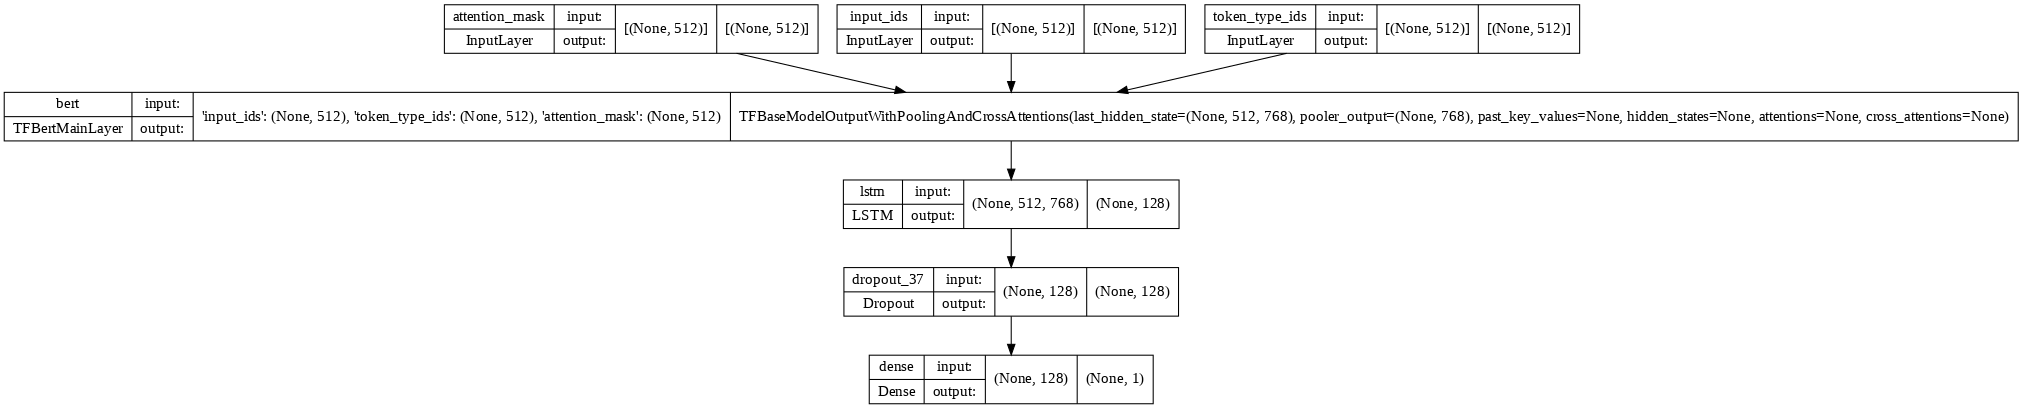

In [ ]:
plot_model(model=model, show_shapes=True, dpi=76, )

# Experiments

Parameters value below are the recommended value by Jacob Devlin in his paper ["BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding"](https://arxiv.org/pdf/1810.04805.pdf). In this experiments, there will be tuning on those values. Unfortunately for batch size testing, it couldn't go above the value of 8, so the testing will be focused more on learning rate of Adam optimizer and number of epochs

• Batch size: 16, 32

• Learning rate (Adam): 5e-5, 3e-5, 2e-5

• Number of epochs: 2, 3, 4

In [ ]:
history = {}

In [ ]:
def main(batch_size, epoch, learning_rate):
    print("[INFO] Compiling Model")
    optimizer = Adam(learning_rate=learning_rate)

    model = generateModel(MODEL_NAME)
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    print("[INFO] Training Model")
    train = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epoch,
        verbose=True,
        validation_data=(x_test, y_test),
    )

    model_name = f'lr-{learning_rate}_ep-{epoch}'

    # Save Training History to analyse model
    history[model_name] = train    

    print("[INFO] Saving Model Evaluation")
    save_to_json(train, model_name)

    print("[INFO] Saving Model")
    model.save_weights(
        f"bert_{model_name}.h5", model
    )
    print("[INFO] Model saved")

    print("[INFO] Saving Prediction")
    y_pred = model.predict(x_test, batch_size=batch_size, verbose=True)
    pickle.dump(
        y_pred,
        open(f"y_pred_{model_name}.pkl", "wb"),
    )
    print("[INFO] Prediction Saved")

In [ ]:
# learning_rate = [2e-5, 3e-5, 5e-5]
# epoch = [4, 3, 2]

# for lr in learning_rate:
#   for ep in epoch:
#     print(f"Learning rate: {lr}")
#     print(f"Epoch        : {ep}")
#     main(8, ep, lr)

In [ ]:
main(8, 3, 5e-5)

[INFO] Compiling Model


Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  167356416   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]',        

2701/2701 [==============================] - 2876s 1s/step - loss: 0.5777 - accuracy: 0.7298 - val_loss: 0.5781 - val_accuracy: 0.7475
Epoch 2/3
2701/2701 [==============================] - 2886s 1s/step - loss: 0.5969 - accuracy: 0.7181 - val_loss: 0.5672 - val_accuracy: 0.7475
Epoch 3/3
 478/2701 [====>.........................] - ETA: 37:38 - loss: 0.6044 - accuracy: 0.7079